In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

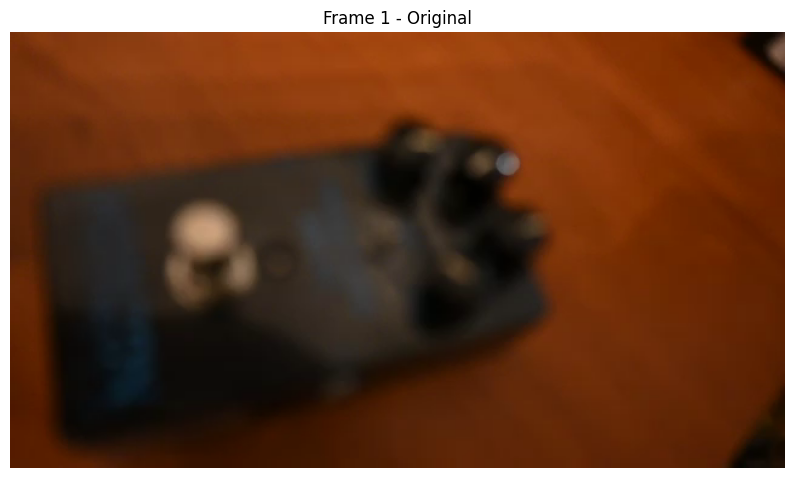

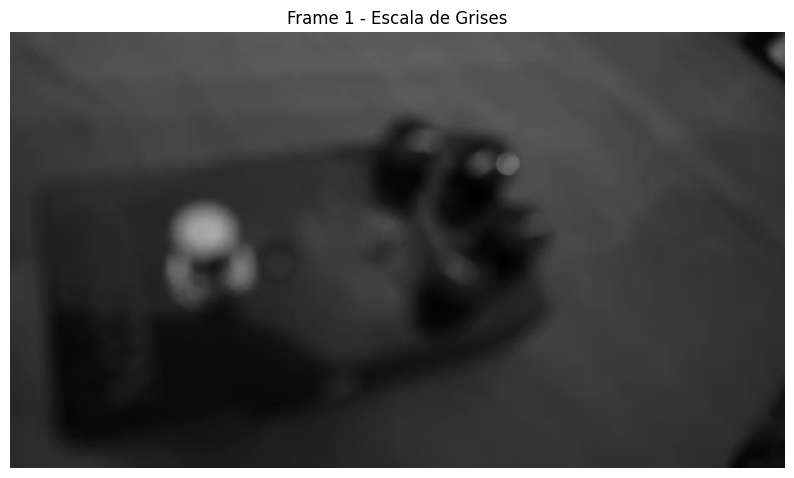

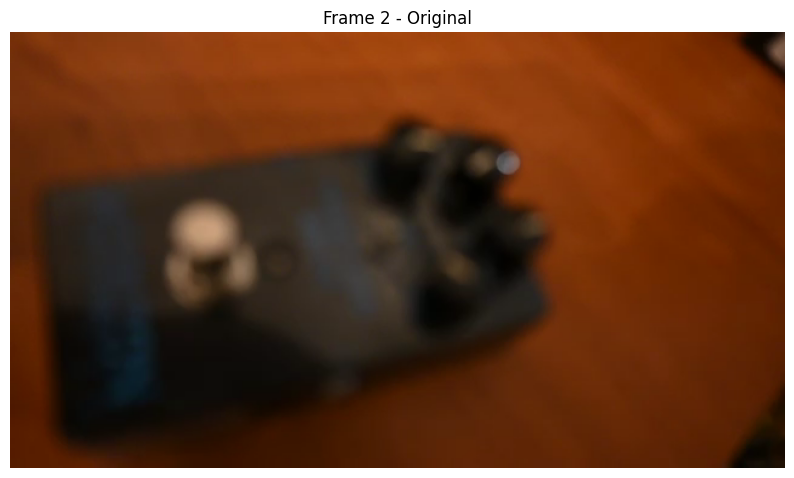

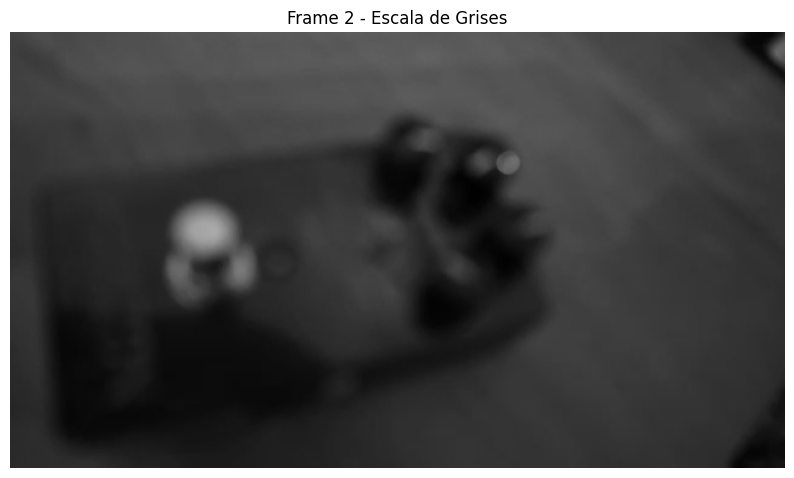

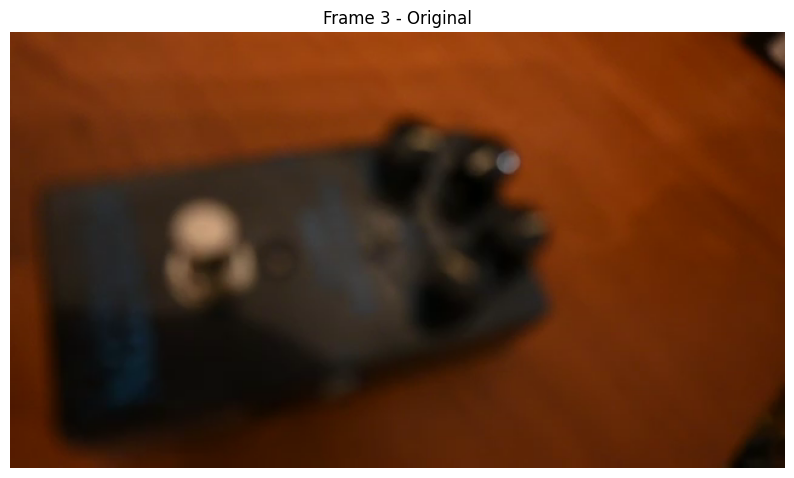

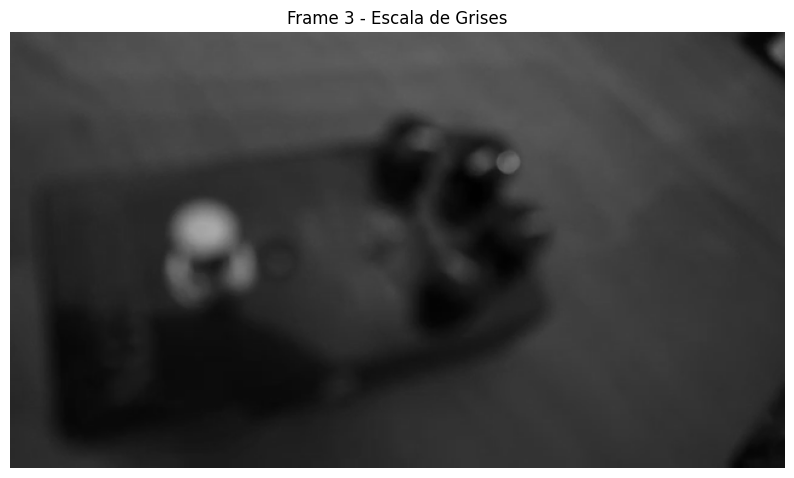

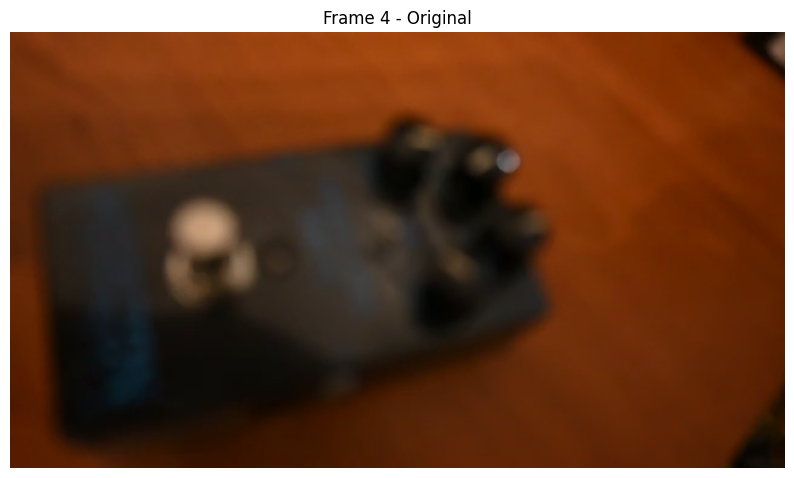

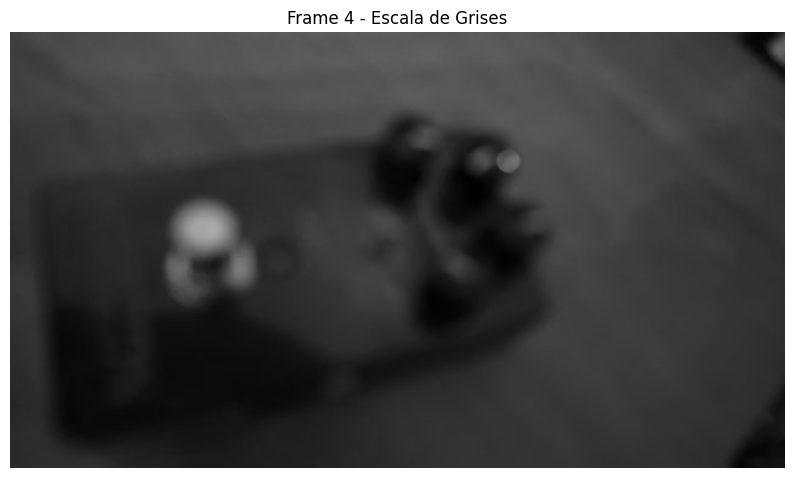

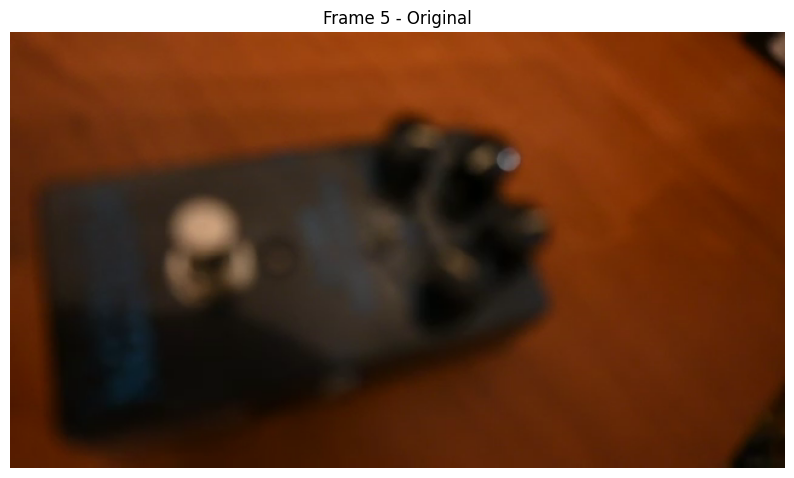

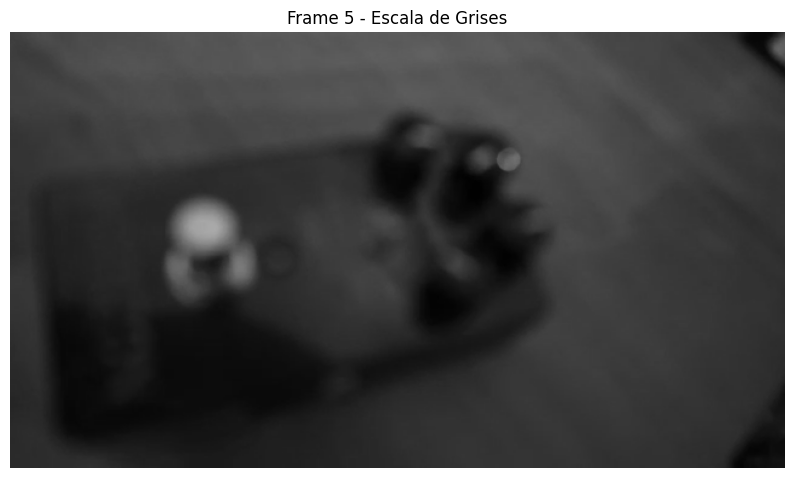

In [5]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Lee los primeros 5 frames del video
    for i in range(5):
        ret, frame = captura_video.read()
        if ret:
            # Procesamiento básico: convertir a escala de grises
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Mostrar el frame original y el frame en escala de grises
            mostrar_imagen(frame, titulo=f'Frame {i+1} - Original')
            mostrar_imagen(frame_gris, titulo=f'Frame {i+1} - Escala de Grises')
        else:
            break

# Libera el objeto de captura de video
captura_video.release()
cv2.destroyAllWindows()

In [ ]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Nuevas dimensiones (mitad del tamaño original)
    new_width = frame_width // 2
    new_height = frame_height // 2
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    #fps = 35
    delay = int(600 / fps)
    
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Reducir el tamaño del frame
        frame_resized = cv2.resize(frame, (new_width, new_height))
        
        # Aplicar blur gaussiano al frame reducido
        frame_blur = cv2.GaussianBlur(frame_resized, (15, 15), 1.5)
        
        # Combina el frame original y el frame con blur lado a lado
        frame_combined = np.hstack((frame_resized, frame_blur))

        # Mostrar el frame combinado
        cv2.imshow('Video Original y Blur Gaussiano', frame_combined)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) and 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.destroyAllWindows()

(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
(180, 640, 3) uint8
